In [1]:
import numpy as np
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from swin_transformer_final import SwinTransformer

In [4]:
model = SwinTransformer(model_name='swin_tiny_224', num_classes=5, include_top=True, pretrained=True)

2024-04-12 17:56:17.701035: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-12 17:56:17.701050: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-12 17:56:17.701054: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-12 17:56:17.701079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-12 17:56:17.701091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model.summary()

Model: "swin_tiny_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embed (PatchEmbed)    multiple                  4896      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 sequential_4 (Sequential)   (None, 49, 768)           27762626  
                                                                 
 norm (LayerNormalization)   multiple                  1536      
                                                                 
 global_average_pooling1d (  multiple                  0         
 GlobalAveragePooling1D)                                         
                                                                 
 head (Dense)                multiple                  3845      
                                                     

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./255, 
                             shear_range = 0.2, 
                             zoom_range = 0.3, 
                             horizontal_flip = True, 
                             validation_split = 0.2)

In [7]:
image_size = (224,224)
batch_size=32

In [8]:
import os

In [9]:
data_path = 'Lung_Disease_Dataset/train'
classes = os.listdir(data_path)
classes = [i for i in classes if not i.startswith('.')]

In [10]:
train_datagen = datagen.flow_from_directory(data_path, 
                                            target_size=image_size, 
                                            batch_size=batch_size, 
                                            class_mode = 'categorical',
                                            subset='training')

valid_datagen = datagen.flow_from_directory(data_path, 
                                            target_size=image_size,
                                            batch_size=batch_size,  
                                            class_mode='categorical', 
                                            subset='validation')

Found 4845 images belonging to 5 classes.
Found 1209 images belonging to 5 classes.


In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
images = []
labels = []


i = 0
while(next(train_datagen)):
    images.extend(list(train_datagen[0][0]))
    labels.extend(list(train_datagen[0][1]))
    print(f"Batch {i} done!")
    i += 1

Batch 0 done!
Batch 1 done!
Batch 2 done!
Batch 3 done!
Batch 4 done!
Batch 5 done!
Batch 6 done!
Batch 7 done!
Batch 8 done!
Batch 9 done!
Batch 10 done!
Batch 11 done!
Batch 12 done!
Batch 13 done!
Batch 14 done!
Batch 15 done!
Batch 16 done!
Batch 17 done!
Batch 18 done!
Batch 19 done!
Batch 20 done!
Batch 21 done!
Batch 22 done!
Batch 23 done!
Batch 24 done!
Batch 25 done!
Batch 26 done!
Batch 27 done!
Batch 28 done!
Batch 29 done!
Batch 30 done!
Batch 31 done!
Batch 32 done!
Batch 33 done!
Batch 34 done!
Batch 35 done!
Batch 36 done!
Batch 37 done!
Batch 38 done!
Batch 39 done!
Batch 40 done!
Batch 41 done!
Batch 42 done!
Batch 43 done!
Batch 44 done!
Batch 45 done!
Batch 46 done!
Batch 47 done!
Batch 48 done!
Batch 49 done!
Batch 50 done!
Batch 51 done!
Batch 52 done!
Batch 53 done!
Batch 54 done!
Batch 55 done!
Batch 56 done!
Batch 57 done!
Batch 58 done!
Batch 59 done!
Batch 60 done!
Batch 61 done!
Batch 62 done!
Batch 63 done!
Batch 64 done!
Batch 65 done!
Batch 66 done!
Batch

KeyboardInterrupt: 

In [35]:
len(images)

7584

In [36]:
len(labels)

7584

In [40]:
images = np.array(images)
labels = np.array(labels)

In [41]:
images.shape

(7584, 224, 224, 3)

In [42]:
labels.shape

(7584, 5)

In [ ]:
model.fit(images, labels, epochs=5)

Epoch 1/5


2024-03-03 16:22:21.422962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


201/237 [========================>.....] - ETA: 1:11 - loss: 2.0845e-04 - accuracy: 0.2030

## Implementation 1

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Concatenate
from tensorflow.keras.models import Model
from swin_transformer_final import SwinTransformerModel, CFGS

def create_model(input_shape_vsi, input_shape_tda, num_classes, pretrained=True, swin_model_type = 'swin_tiny_224'):
    # Inputs for VSI and TDA images
    input_vsi = Input(shape=input_shape_vsi)
    input_tda = Input(shape=input_shape_tda)

    # Initial Convolutional layer for each input
    conv_vsi = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_vsi)
    conv_tda = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_tda)

    # Load the Swin Transformer model configuration
    swin_config = CFGS[swin_model_type]
    swin_transformer_model = SwinTransformerModel(include_top=False, num_classes=num_classes, **swin_config)
    model_name = swin_model_type

    ###################################
    if pretrained is True:
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_weights = tf.keras.utils.get_file(model_name, url, untar=True)
    else:
        pretrained_weights = pretrained
    
    # Load weights into the model if pretrained_weights is provided
    if pretrained_weights:
        if tf.io.gfile.isdir(pretrained_weights):
            pretrained_weights = f'{pretrained_weights}/{model_name}.ckpt'
        
        
    swin_transformer_model.load_weights(pretrained_weights)
    #####################################

    # Swin Transformer Encoder blocks for VSI and TDA images
    swin_output_vsi = swin_transformer_model(conv_vsi)
    swin_output_tda = swin_transformer_model(conv_tda)

    # Concatenate the output features from the Swin Transformer encoders
    concatenated = Concatenate()([swin_output_vsi, swin_output_tda])

    # Classifier head
    classifier_output = Dense(num_classes, activation='softmax')(concatenated)

    # Create the Model
    model = Model(inputs=[input_vsi, input_tda], outputs=classifier_output)

    return model

# Define input shapes based on the preprocessed data sizes
input_shape_vsi = (224, 224, 1)  # Replace with actual size
input_shape_tda = (224, 224, 3)  # Replace with actual size
num_classes = 2  # Healthy or Diseased

# Create the model
model = create_model(input_shape_vsi, input_shape_tda, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         640       ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         1792      ['input_3[0][0]']             
                                                                                              

In [13]:
input_shape_vsi = (224, 224, 1)  # Replace with actual size
input_shape_tda = (224, 224, 3)  # Replace with actual size
num_classes = 2  # Healthy or Diseased

# Create the model
model1 = create_model(input_shape_vsi, input_shape_tda, num_classes, swin_model_type='swin_small_224', pretrained=True)

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 224, 224, 64)         640       ['input_4[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 224, 224, 64)         1792      ['input_5[0][0]']             
                                                                                            

## Implementation 2

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Concatenate
from tensorflow.keras.models import Model
from swin_transformer_final import SwinTransformerModel, CFGS

def create_model(input_shape_rgb, input_shape_vsi, input_shape_tda, num_classes, pretrained=True, swin_model_type='swin_tiny_224'):
    # Inputs for RGB, VSI, and TDA images
    input_rgb = Input(shape=input_shape_rgb)
    input_vsi = Input(shape=input_shape_vsi)
    input_tda = Input(shape=input_shape_tda)

    # Initial Convolutional layer for each input
    conv_rgb = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_rgb)
    conv_vsi = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_vsi)
    conv_tda = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_tda)

    # Load the Swin Transformer model configuration
    swin_config = CFGS[swin_model_type]
    swin_transformer_model = SwinTransformerModel(include_top=False, num_classes=num_classes, **swin_config)
    model_name = swin_model_type

    ###################################
    if pretrained is True:
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_weights = tf.keras.utils.get_file(model_name, url, untar=True)
    else:
        pretrained_weights = pretrained
    
    # Load weights into the model if pretrained_weights is provided
    if pretrained_weights:
        if tf.io.gfile.isdir(pretrained_weights):
            pretrained_weights = f'{pretrained_weights}/{model_name}.ckpt'
        
        
    swin_transformer_model.load_weights(pretrained_weights)
    #####################################

    # Swin Transformer Encoder blocks for RGB, VSI, and TDA images
    swin_output_rgb = swin_transformer_model(conv_rgb)
    swin_output_vsi = swin_transformer_model(conv_vsi)
    swin_output_tda = swin_transformer_model(conv_tda)

    # Concatenate the output features from all Swin Transformer encoders
    concatenated = Concatenate()([swin_output_rgb, swin_output_vsi, swin_output_tda])

    # Classifier head
    classifier_output = Dense(num_classes, activation='softmax')(concatenated)

    # Create the Model
    model = Model(inputs=[input_rgb, input_vsi, input_tda], outputs=classifier_output)

    return model

# Define input shapes based on the preprocessed data sizes
input_shape_rgb = (224, 224, 3)  # Adjust based on your RGB image size
input_shape_vsi = (224, 224, 1)  # Replace with actual size for VSI images
input_shape_tda = (224, 224, 3)  # Replace with actual size for TDA images
num_classes = 2  # Healthy or Diseased

# Create the model
model = create_model(input_shape_rgb, input_shape_vsi, input_shape_tda, num_classes, swin_model_type='swin_large_224')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 224, 224, 64)         1792      ['input_6[0][0]']             
                                                                                            

## Implementation 3

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Concatenate
from tensorflow.keras.models import Model
from swin_transformer_final import SwinTransformerModel, CFGS

def create_swin_encoder(input_shape, swin_model_type, pretrained=True, layer_img='rgb'):
    # Load the Swin Transformer model configuration
    swin_config = CFGS[swin_model_type]
    swin_transformer = SwinTransformerModel(include_top=False, **swin_config)
    
    # Load pretrained weights if specified
    if pretrained:
        model_name = swin_model_type
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_weights = tf.keras.utils.get_file(fname=model_name, origin=url, untar=True)
        if tf.io.gfile.isdir(pretrained_weights):
            pretrained_weights = f'{pretrained_weights}/{model_name}.ckpt'
        swin_transformer.load_weights(pretrained_weights)
    
    # Define the input layer
    input_layer = Input(shape=input_shape)

    # Forward pass up to the global average pooling
    x = swin_transformer.patch_embedding(input_layer)
    x = swin_transformer.basic_layers(x)
    x = swin_transformer.normalization_layer(x)
    x = swin_transformer.global_average_pooling(x)

    # If the model does not output a 1000-dimensional vector, use a Dense layer to project it
    if swin_transformer.n_features != 1000:
        x = Dense(1000)(x)

    # Create a model
    return Model(input_layer, x, name=f'{swin_model_type}_encoder_{layer_img}')


# Define input shapes
input_shape_rgb = (224, 224, 3)
input_shape_vsi = (224, 224, 3)
input_shape_tda = (224, 224, 3)

# Create Swin Transformer encoders for each input type
swin_encoder_rgb = create_swin_encoder(input_shape_rgb, 'swin_small_224', layer_img='rgb')
swin_encoder_vsi = create_swin_encoder(input_shape_vsi, 'swin_small_224', layer_img='vsi')
swin_encoder_tda = create_swin_encoder(input_shape_tda, 'swin_small_224', layer_img='tda')

# Inputs for RGB, VSI, and TDA images
input_rgb = Input(shape=input_shape_rgb, name='input_rgb')
input_vsi = Input(shape=(224,224,1), name='input_vsi')
input_tda = Input(shape=input_shape_tda, name='input_tda')

input_after_conv_vsi = Conv2D(3, kernel_size=(3,3), padding='same', activation='relu')(input_vsi)

# Process each input through its respective Swin Transformer encoder
features_rgb = swin_encoder_rgb(input_rgb)
features_vsi = swin_encoder_vsi(input_after_conv_vsi)
features_tda = swin_encoder_tda(input_tda)

# Concatenate the output features from all Swin Transformer encoders
concatenated_features = Concatenate()([features_rgb, features_vsi, features_tda])

# Classifier head
classifier_output = Dense(2, activation='softmax', name='classifier')(concatenated_features)

# Create the combined Model
combined_model = Model(inputs=[input_rgb, input_after_conv_vsi, input_tda], outputs=classifier_output)

# Compile the combined model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_rgb (InputLayer)      [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_tda (InputLayer)      [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 swin_small_224_encoder_rgb  (None, 1000)                 4994239   ['input_rgb[0][0]']           
  (Functional)                                            8                                 

# Implementation with just RGB + VSI Patched Images

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Concatenate
from tensorflow.keras.models import Model
from swin_transformer_final import SwinTransformerModel, CFGS

def create_swin_encoder(input_shape, swin_model_type, pretrained=True, layer_img='rgb'):
    # Load the Swin Transformer model configuration
    swin_config = CFGS[swin_model_type]
    swin_transformer = SwinTransformerModel(include_top=False, **swin_config)
    
    # Load pretrained weights if specified
    if pretrained:
        model_name = swin_model_type
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_weights = tf.keras.utils.get_file(fname=model_name, origin=url, untar=True)
        if tf.io.gfile.isdir(pretrained_weights):
            pretrained_weights = f'{pretrained_weights}/{model_name}.ckpt'
        swin_transformer.load_weights(pretrained_weights)
    
    # Define the input layer
    input_layer = Input(shape=input_shape)

    # Forward pass up to the global average pooling
    x = swin_transformer.patch_embedding(input_layer)
    x = swin_transformer.basic_layers(x)
    x = swin_transformer.normalization_layer(x)
    x = swin_transformer.global_average_pooling(x)

    # If the model does not output a 1000-dimensional vector, use a Dense layer to project it
    if swin_transformer.n_features != 1000:
        x = Dense(1000)(x)

    # Create a model
    return Model(input_layer, x, name=f'{swin_model_type}_encoder_{layer_img}')


# Define input shapes
input_shape_rgb = (224, 224, 3)
input_shape_vsi = (224, 224, 3)
# input_shape_tda = (224, 224, 3)

# Create Swin Transformer encoders for each input type
swin_encoder_rgb = create_swin_encoder(input_shape_rgb, 'swin_tiny_224', layer_img='rgb')
swin_encoder_vsi = create_swin_encoder(input_shape_vsi, 'swin_tiny_224', layer_img='vsi')
# swin_encoder_tda = create_swin_encoder(input_shape_tda, 'swin_small_224', layer_img='tda')

# Inputs for RGB, VSI, and TDA images
input_rgb = Input(shape=input_shape_rgb, name='input_rgb')
input_vsi = Input(shape=(224,224,1), name='input_vsi')
# input_tda = Input(shape=input_shape_tda, name='input_tda')

input_after_conv_vsi = Conv2D(3, kernel_size=(3,3), padding='same', activation='relu')(input_vsi)

# Process each input through its respective Swin Transformer encoder
features_rgb = swin_encoder_rgb(input_rgb)
features_vsi = swin_encoder_vsi(input_after_conv_vsi)
# features_tda = swin_encoder_tda(input_tda)

# Concatenate the output features from all Swin Transformer encoders
concatenated_features = Concatenate()([features_rgb, features_vsi]) # , features_tda

# Classifier head
classifier_output = Dense(2, activation='softmax', name='classifier')(concatenated_features)

2024-04-12 23:13:56.448146: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-12 23:13:56.448162: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-12 23:13:56.448170: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-12 23:13:56.448196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-12 23:13:56.448213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
for layer in swin_encoder_rgb.layers[:-1]:
    layer.trainable = False

# Freeze the Swin Transformer layers for VSI encoder
for layer in swin_encoder_vsi.layers[:-1]:
    layer.trainable = False

In [3]:
# Create the combined Model
combined_model = Model(inputs=[input_rgb, input_vsi], outputs=classifier_output) # , input_tda

# Compile the combined model
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_vsi (InputLayer)      [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_rgb (InputLayer)      [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 3)          30        ['input_vsi[0][0]']           
                                                                                                  
 swin_tiny_224_encoder_rgb   (None, 1000)                 2853805   ['input_rgb[0][0]']           
 (Functional)                                             8                                   

In [4]:
# Verify that the layers are frozen
for layer in combined_model.layers:
    print(layer.name, layer.trainable)

input_vsi True
input_rgb True
conv2d True
swin_tiny_224_encoder_rgb True
swin_tiny_224_encoder_vsi True
concatenate True
classifier True


In [5]:
# Check the trainable status of the layers in swin_encoder_rgb
print("Trainable status of layers in swin_encoder_rgb:")
for layer in swin_encoder_rgb.layers:
    print(layer.name, layer.trainable)

# Check the trainable status of the layers in swin_encoder_vsi
print("\nTrainable status of layers in swin_encoder_vsi:")
for layer in swin_encoder_vsi.layers:
    print(layer.name, layer.trainable)


Trainable status of layers in swin_encoder_rgb:
input_1 False
patch_embed False
sequential_4 False
norm False
global_average_pooling1d False
dense True

Trainable status of layers in swin_encoder_vsi:
input_2 False
patch_embed False
sequential_9 False
norm False
global_average_pooling1d_1 False
dense_1 True


In [10]:
import numpy as np
train_rgb, train_labels = np.load('./training_data/images_rgb.npy'), np.load('./training_data/image_labels.npy')

In [11]:
train_vessels, train_labels_v = np.load('./training_data/vessels_seg.npy'), np.load('./training_data/vessels_seg.npy')

In [12]:
train_rgb.shape

(3150, 224, 224, 3)

In [13]:
train_vessels.shape

(3150, 224, 224)

In [14]:
train_vessels = train_vessels.reshape(3150,224,224,1)

In [15]:
train_vessels.shape

(3150, 224, 224, 1)

In [16]:
import matplotlib.pyplot as plt

In [17]:
final_training = [train_rgb, train_vessels]

In [18]:
train_vessels[0].shape

(224, 224, 1)

In [16]:
combined_model.fit(final_training, train_labels, epochs=5)

Epoch 1/5


2024-04-12 23:14:53.369578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 258s 2s/step - loss: 1.2522 - accuracy: 0.6562
Epoch 2/5
99/99 [==============================] - 223s 2s/step - loss: 0.5734 - accuracy: 0.7321
Epoch 3/5
99/99 [==============================] - 236s 2s/step - loss: 0.5827 - accuracy: 0.7298
Epoch 4/5
99/99 [==============================] - 252s 3s/step - loss: 0.4978 - accuracy: 0.7679
Epoch 5/5
99/99 [==============================] - 242s 2s/step - loss: 0.6245 - accuracy: 0.7105


In [18]:
y_pred = combined_model.predict(final_training)

99/99 [==============================] - 134s 1s/step


In [19]:
np.save('y_pred_rgb_vsi.npy', y_pred)

In [20]:
from sklearn.metrics import roc_curve
roc = roc_curve(train_labels, y_pred[:,1])
fpr, tpr = roc[0], roc[1]

---

# All Channels - RGB + VSI + TDA

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Concatenate
from tensorflow.keras.models import Model
from swin_transformer_final import SwinTransformerModel, CFGS

def create_swin_encoder(input_shape, swin_model_type, pretrained=True, layer_img='rgb'):
    # Load the Swin Transformer model configuration
    swin_config = CFGS[swin_model_type]
    swin_transformer = SwinTransformerModel(include_top=False, **swin_config)
    
    # Load pretrained weights if specified
    if pretrained:
        model_name = swin_model_type
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_weights = tf.keras.utils.get_file(fname=model_name, origin=url, untar=True)
        if tf.io.gfile.isdir(pretrained_weights):
            pretrained_weights = f'{pretrained_weights}/{model_name}.ckpt'
        swin_transformer.load_weights(pretrained_weights)
    
    # Define the input layer
    input_layer = Input(shape=input_shape)

    # Forward pass up to the global average pooling
    x = swin_transformer.patch_embedding(input_layer)
    x = swin_transformer.basic_layers(x)
    x = swin_transformer.normalization_layer(x)
    x = swin_transformer.global_average_pooling(x)

    # If the model does not output a 1000-dimensional vector, use a Dense layer to project it
    if swin_transformer.n_features != 1000:
        x = Dense(1000)(x)

    # Create a model
    return Model(input_layer, x, name=f'{swin_model_type}_encoder_{layer_img}')


# Define input shapes
input_shape_rgb = (224, 224, 3)
input_shape_vsi = (224, 224, 3)
input_shape_tda = (224, 224, 3)

# Create Swin Transformer encoders for each input type
swin_encoder_rgb = create_swin_encoder(input_shape_rgb, 'swin_tiny_224', layer_img='rgb')
swin_encoder_vsi = create_swin_encoder(input_shape_vsi, 'swin_tiny_224', layer_img='vsi')
swin_encoder_tda = create_swin_encoder(input_shape_tda, 'swin_tiny_224', layer_img='tda')

# Inputs for RGB, VSI, and TDA images
input_rgb = Input(shape=input_shape_rgb, name='input_rgb')
input_vsi = Input(shape=(224,224,1), name='input_vsi')
input_tda = Input(shape=input_shape_tda, name='input_tda')

input_after_conv_vsi = Conv2D(3, kernel_size=(3,3), padding='same', activation='relu')(input_vsi)

# Process each input through its respective Swin Transformer encoder
features_rgb = swin_encoder_rgb(input_rgb)
features_vsi = swin_encoder_vsi(input_after_conv_vsi)
features_tda = swin_encoder_tda(input_tda)

# Concatenate the output features from all Swin Transformer encoders
concatenated_features = Concatenate()([features_rgb, features_vsi, features_tda])

# Classifier head
classifier_output = Dense(2, activation='softmax', name='classifier')(concatenated_features)

2024-04-27 14:41:20.283247: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-27 14:41:20.283265: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-27 14:41:20.283269: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-27 14:41:20.283295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-27 14:41:20.283306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
for layer in swin_encoder_rgb.layers[:-1]:
    layer.trainable = False

# Freeze the Swin Transformer layers for VSI encoder
for layer in swin_encoder_vsi.layers[:-1]:
    layer.trainable = False

for layer in swin_encoder_tda.layers[:-1]:
    layer.trainable = False

In [5]:
# Check the trainable status of the layers in swin_encoder_rgb
print("Trainable status of layers in swin_encoder_rgb:")
for layer in swin_encoder_rgb.layers:
    print(layer.name, layer.trainable)

# Check the trainable status of the layers in swin_encoder_vsi
print("\nTrainable status of layers in swin_encoder_vsi:")
for layer in swin_encoder_vsi.layers:
    print(layer.name, layer.trainable)

print("\nTrainable status of layers in swin_encoder_tda:")
for layer in swin_encoder_tda.layers:
    print(layer.name, layer.trainable)

Trainable status of layers in swin_encoder_rgb:
input_1 False
patch_embed False
sequential_4 False
norm False
global_average_pooling1d False
dense True

Trainable status of layers in swin_encoder_vsi:
input_2 False
patch_embed False
sequential_9 False
norm False
global_average_pooling1d_1 False
dense_1 True

Trainable status of layers in swin_encoder_tda:
input_3 False
patch_embed False
sequential_14 False
norm False
global_average_pooling1d_2 False
dense_2 True


In [6]:
# Create the combined Model
combined_model = Model(inputs=[input_rgb, input_vsi, input_tda], outputs=classifier_output) # , input_tda

# Compile the combined model
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_vsi (InputLayer)      [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_rgb (InputLayer)      [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 3)          30        ['input_vsi[0][0]']           
                                                                                                  
 input_tda (InputLayer)      [(None, 224, 224, 3)]        0         []                            
                                                                                              

In [7]:
train_tda = np.load('./training_data/tda_vr.npy')

In [8]:
train_tda.shape

(3150, 224, 224, 3)

In [19]:
training_final = [train_rgb, train_vessels, train_tda]

In [20]:
combined_model.fit(training_final, train_labels, epochs=8)

Epoch 1/8


2024-04-27 14:42:45.485614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 414s 4s/step - loss: 2.1077 - accuracy: 0.6321
Epoch 2/8
99/99 [==============================] - 417s 4s/step - loss: 0.6206 - accuracy: 0.6775
Epoch 3/8
99/99 [==============================] - 415s 4s/step - loss: 0.6487 - accuracy: 0.6695
Epoch 4/8
99/99 [==============================] - 408s 4s/step - loss: 0.5577 - accuracy: 0.7140
Epoch 5/8
99/99 [==============================] - 423s 4s/step - loss: 0.5673 - accuracy: 0.7114
Epoch 6/8
99/99 [==============================] - 410s 4s/step - loss: 0.5342 - accuracy: 0.7286
Epoch 7/8
99/99 [==============================] - 448s 5s/step - loss: 0.5216 - accuracy: 0.7429
Epoch 8/8
99/99 [==============================] - 454s 5s/step - loss: 0.5170 - accuracy: 0.7470


In [21]:
from sklearn.metrics import roc_curve

In [22]:
y_pred = combined_model.predict(training_final)

99/99 [==============================] - 254s 2s/step


---

In [23]:
np.save('y_pred_all_channels_vr.npy', y_pred)

In [24]:
y_pred_cb_3 = np.load('y_pred_all_channels_cb.npy')
y_pred_vr_3 = np.load('y_pred_all_channels_vr.npy')
y_pred2 = np.load('y_pred_rgb_vsi.npy')

In [25]:
roc = roc_curve(train_labels, y_pred2[:,1])
roc_cb = roc_curve(train_labels, y_pred_cb_3[:,1])
roc_vr = roc_curve(train_labels, y_pred_vr_3[:,1])

In [26]:
fpr, tpr = roc[0], roc[1]
fpr_vr, tpr_vr = roc_vr[0], roc_vr[1]
fpr_cb, tpr_cb = roc_cb[0], roc_cb[1]

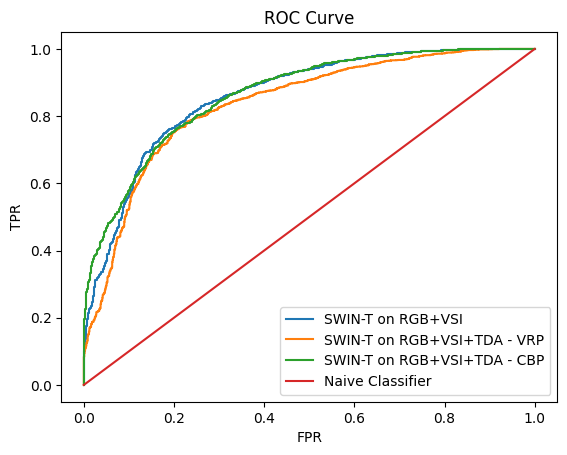

In [27]:
plt.plot(fpr, tpr, label = 'SWIN-T on RGB+VSI')
plt.plot(fpr_vr, tpr_vr, label = 'SWIN-T on RGB+VSI+TDA - VRP')
plt.plot(fpr_cb, tpr_cb, label = 'SWIN-T on RGB+VSI+TDA - CBP')
plt.plot([0,1],[0,1], label='Naive Classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC Curve')
plt.savefig('ROC.jpeg', dpi=600)
plt.show()

In [1]:
import numpy as np

In [2]:
y_pred_all_channels = np.load('y_pred_all_channels.npy')

In [37]:
def split_and_majority(data):
    # Splitting the array into chunks of size 70
    n = 70
    mini_arrays = [data[i:i + n] for i in range(0, len(data), n)]
    
    # Calculating the majority for each mini array
    majority = [1 if np.sum(chunk) > 69 else 0 for chunk in mini_arrays]
    
    return majority

# Example array
data = train_labels  # Replace this with your actual data array

# Call the function
result = split_and_majority(data)
print(result)

[1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]


In [38]:
y_pred_int = np.argmax(y_pred_all_channels, axis=1)

In [39]:
result1 = split_and_majority(y_pred_int)

In [40]:
result1

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1]

In [41]:
y_pred_int

array([1, 1, 1, ..., 1, 1, 1])

In [42]:
np.sum(y_pred_int)

3116

In [43]:
y_pred_all_channels[0]

array([0.02717963, 0.9728204 ], dtype=float32)

In [44]:
np.sum(np.array(result)==np.array(result1))

35

In [45]:
35/45

0.7777777777777778

In [46]:
from sklearn.metrics import roc_auc_score

In [48]:
roc_auc_score(train_labels, y_pred_all_channels[:,1])

0.8645315192743763